<a href="https://colab.research.google.com/github/ArturoAA95/TransmisionProblem/blob/master/TestTransmision2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from random import seed
from random import randint
import sys
import os
import scipy
from scipy.optimize import root_scalar
from scipy.optimize import brentq
from scipy.sparse.linalg import spsolve
import heapq

#Source term

In [186]:
def f_1(x, y):
  return .5*np.sin(2*np.pi*(x/200))*np.cos(2*np.pi*(x/200)) + 1

def f(x, y):
  return 1

#Operator

In [187]:
def H1(a1, a2, a3, a4, x ,y):
  return min(a1, a2, a3, a4) + 1

def H2(a1, a2, a3, a4, x, y):
  a = min(a1, a2)
  b = min(a3, a4)
  c = f_1(x, y)
  if c > np.abs(a-b):
    return .5*(a + b + np.sqrt(2*c**2 - (a-b)**2))
  else:
    return c**2 + min(a, b)

def H(a1, a2, a3, a4, x, y):
  a = min(a1, a2)
  b = min(a3, a4)
  c = 1
  if c > np.abs(a-b):
    return .5*(a + b + np.sqrt(2*c**2 - (a-b)**2))
  else:
    return c**2 + min(a, b)

def G(a1, a2, a3, a4, a, x, y):
  return np.sqrt( min(a-a1, a-a2, 0)**2 + min(a-a3, a-a4, 0)**2 ) - 1

def G2(a1, a2, a3, a4, a, x, y):
  return np.sqrt( min(a-a1, a-a2, 0)**2 + min(a-a3, a-a4, 0)**2 ) - f_1(x, y)

def S(a1, a2, a3, a4):
  return .25*(a1+a2+a3+a4)

#def G_Anis(z, a1, a2, a3, a4):
#  aux = max(0, z-a3, z-a4)
#  if aux
#  return np.sqrt( /  )

#Interface

In [188]:
#For 250
def I_1(i):
  return 110+int(15*np.sin((i+63)/40))

def I(i):
  return 220+int(30*np.sin((i+126)/40))

def I_2(i):
  return 200

def I_3(i):
  return 100

#Fast Marching Method -- Checked

In [189]:
def InitializeNarrowBand(NB, om, dist, N, H):
  for i in range(N):
    for j in range(N):
      if om[i, j] > 0 and om[i, j] < 3: #Run over eikonal
        if om[i+1, j] == 0:
            aux = H(dist[i+1, j], dist[i-1, j], dist[i, j+1], dist[i, j-1], i, j)
        elif om[i-1, j] == 0:
            aux = H(dist[i+1, j], dist[i-1, j], dist[i, j+1], dist[i, j-1], i, j)
        elif om[i, j+1] == 0:
            aux = H(dist[i+1, j], dist[i-1, j], dist[i, j+1], dist[i, j-1], i, j)
        elif om[i, j-1] == 0:
            aux = H(dist[i+1, j], dist[i-1, j], dist[i, j+1], dist[i, j-1], i, j)
        else:
          continue  #The index is not added to the narrow band
        new_dist = np.copy(aux)
        if new_dist < dist[i, j]:
          dist[i, j] = new_dist
          x = [i, j]
          heapq.heappush(NB, (new_dist, x))

def UpdateDistance(NB, om, dist, N, H, i_aux, j_aux):
    #Update the distance of i_aux, j_aux
    new_dist = H(dist[i_aux+1, j_aux], dist[i_aux-1, j_aux], dist[i_aux, j_aux+1], dist[i_aux, j_aux-1], i_aux, j_aux)
    #Only update if the distance is smaller than the current distance
    if new_dist < dist[i_aux, j_aux]:
        dist[i_aux, j_aux] = new_dist
        heapq.heappush(NB, (new_dist, [i_aux, j_aux]))


def FastMarchingMethod2D(NB, om, dist, N, H): #Solves Eikonal equation
  #Inicialice narrow band
  InitializeNarrowBand(NB, om, dist, N, H)
  #Compute solution
  #Loop until narrow band is empty
  while len(NB)>0 :
    #Pop the element with the least distance in the narrow band
    c_dist, c_vert = heapq.heappop(NB)
    i = int(c_vert[0])
    j = int(c_vert[1])
    #The vertex (i,j) becomes a boundary point
    om[i, j] = 0
    # Check if we have already poped the vertex
    if c_dist > dist[i, j]:
      continue
    #Update distance for neighbors of current_vertex
    #Update the distance of the neighbor upwards
    if om[i+1, j] > 0 and om[i+1, j] < 3: #Restrict to Eikonal
      i_aux = i+1
      j_aux = j
      UpdateDistance(NB, om, dist, N, H, i_aux, j_aux)
    #Update the distance of the neighbor downwards
    if om[i-1, j] > 0 and om[i-1, j] < 3: #Restrict to Eikonal
      i_aux = i-1
      j_aux = j
      UpdateDistance(NB, om, dist, N, H, i_aux, j_aux)
    #Update the distance of the neighbor to the right
    if om[i, j+1] > 0 and om[i, j+1] < 3: #Restrict to Eikonal
      i_aux = i
      j_aux = j+1
      UpdateDistance(NB, om, dist, N, H, i_aux, j_aux)
    #Update the distance of the neighbor to the left
    if om[i, j-1] > 0 and om[i, j-1] < 3: #Restrict to Eikonal
      i_aux = i
      j_aux = j-1
      UpdateDistance(NB, om, dist, N, H, i_aux, j_aux)
  #Return the distance matrix
  return dist


#Interfase functions

#Test building domain

In [190]:
def CreateInterfase(om, k, N, I):
  for i in range(1, N-1):
    om[i, I(i)] = k

def Build_Eik_Brown(om, N):
  for i in range (1, N-1):
    j = 1
    while om[i,j] != 2 and j<N-1: #Eikonal
      om[i,j] = 1
      j = j+1
    j = j+1
    while j < N-1:  #Brownian
      om[i,j] = 3
      j = j+1

#N = 250

#We give codes to each region of the domain
# 0 -> Fixed point (Boundary and non-used)
# 1 -> Eikonal
# 2 -> Interface
# 3 -> Brownian

#om = np.zeros((N,N))
#Construction of Interface
#CreateInterfase(om, 2, N, I_3)
#Construction of Domain
#Build_Eik_Brown(om, N)

#plt.imshow(om)
#plt.colorbar()

#Test fast marching method

In [191]:
def InitializeDistances(om, N):
   dist = np.zeros((N,N))
   for i in range(N):
    for j in range(N):
       if om[i, j] > 0:
          dist[i, j] = np.inf
   return dist

#Omega = np.copy(om)   ### We preserve the structure of the domain
#dist = InitializeDistances(om, N)
#NB = []
#eik_0 = FastMarchingMethod2D(NB, Omega, dist, N, H)        ### Omega is modified
#plt.imshow(eik_0)
#plt.colorbar()

#Brownian system

In [192]:
from scipy import sparse

def HashTablesBrownian(om, N):
  #Create hash tables for Brownian
  C_to_P = {}
  P_to_C = {}
  dim = 0
  for i in range(N):
    for j in range(N):
      if om[i,j] == 3:
        C_to_P[i,j] = dim
        P_to_C[dim] = [i,j]
        dim = dim + 1
  return C_to_P, P_to_C, dim

#Give coordinates and receive position in vector
def Coord_to_Pos(x, y, C_to_P):
  return C_to_P[x,y]

#Give position in vector and receive coordinates
def Pos_to_Coord(l, P_to_C):
  return P_to_C[l]

def CreateMatrixBrownian(C_to_P, P_to_C, dim, om):
  #Create sparse matrix for Brownian
  A = sparse.csr_matrix((dim, dim))
  A = A.tolil()

  #Construct linear system for the Brownian region
  for l in range(dim):
    A[l,l] = -4
    x, y = Pos_to_Coord(l, P_to_C)
    #Check if (x,y) has a neighbor to the left and if it's in the Brownian region
    if om[x, y-1] == 3:
      A[l, Coord_to_Pos(x, y-1, C_to_P)] = 1
    #Check if (x,y) has a neighbor to the right and if it's in the Brownian region
    if om[x, y+1] == 3:
      A[l, Coord_to_Pos(x, y+1, C_to_P)] = 1
    #Check if (x,y) has a neighbor upwards and if it's in the Brownian region
    if om[x-1, y] == 3:
      m = Coord_to_Pos(x-1, y, C_to_P)
      A[l, m] = 1
    #Check if (x,y) has a neighbor downwards and if it's in the Brownian region
    if om[x+1, y] == 3:
      m = Coord_to_Pos(x+1, y, C_to_P)
      A[l, m] = 1

  A = A.tocsr()
  return A

#Functions to update Interfase
def Update_b(sol, CtoP, dim, om, I, N):
  b = np.zeros(dim)
  for i in range(1, N-1):
    x = i
    y = I(i)
    l = Coord_to_Pos(x, y+1, CtoP)
    b[l] = b[l] - sol[x, y]
    if om[x+1, y+1] != 3:
      b[l] = b[l] - sol[x+1, y+1]
    if om[x-1, y+1] != 3:
      b[l] = b[l] - sol[x-1, y+1]
  return b

#Receives vector obtained when solving Laplaces equation and copies it to the solution matrix
def Update_sol_I(sol, sol_brow, dim, N, CtoP, I, om):
  #print(CtoP)
  for i in range(1, N-1):
    x = i
    y = I(i)
    #print(x, y)
    l = Coord_to_Pos(x, y+1, CtoP)
    sol[x, y+1] = sol_brow[l]
    if om[x+1, y] == 3:
      #print(x+1, y)
      l = Coord_to_Pos(x+1, y, CtoP)
      sol[x+1, y] = sol_brow[l]
    if om[x-1, y] == 3:
      #print(x-1, y+1)
      l = Coord_to_Pos(x-1, y, CtoP)
      sol[x-1, y] = sol_brow[l]
  return sol

def Update_sol(sol, sol_brow, dim, PtoC):
  for l in range(dim):
    x, y = Pos_to_Coord(l, PtoC)
    sol[x, y] = sol_brow[l]
  return sol

#Test Brownian system

In [193]:
#C_to_P, P_to_C, dim = HashTablesBrownian(om, N)
#A = CreateMatrixBrownian(C_to_P, P_to_C, dim, Omega)

#Initialize solution
#b = Update_b(eik_0, C_to_P, dim, om, I_3, N)

#Actualiza_b(sol_0, dim, Iy, vT, hT, N)
#x = spsolve(A, b)
#sol = Update_sol(eik_0, x, dim, P_to_C)
#sol = Update_sol(eik_0, x, dim, N, C_to_P, f)
#plt.imshow(sol)
#plt.colorbar()

#st = np.copy(sol)

#Interface
#CreateInterfase(om, 2, N, I_3)

In [194]:
def Update_Interfase(sol_0, N, I, H, G):
  error = np.zeros(N-2)
  for i in range(1, N-1):
    x = i
    y = I(i)
    a = sol_0[x, y]
    a_1 = sol_0[x, y+1]
    a_2 = sol_0[x, y-1]
    a_3 = sol_0[x+1, y]
    a_4 = sol_0[x-1, y]
    aux1 = H(a_1, a_2, a_3, a_4, x, y)
    #aux = np.copy(G(a_1, a_2, a_3, a_4, a, x, y))
    #aux2 = G(a_1, a_2, a_3, a_4, a, x, y)
    #aux3 = S(a_1, a_2, a_3, a_4)-a
    #aux = min(aux3, aux2)
    if sol_0[x, y] > aux1:
      sol_0[x, y] = aux1
    #error[i-1] = aux
    #if aux > error:
    #  error = aux
  #return error


def InitializeOnePlayer(omega, CtoP, PtoC, N, H, dim, I, A):
  O = np.copy(omega)   ### We preserve the structure of the domain
  #Solve Eikonal equation in Brownian region
  dist = InitializeDistances(O, N)
  NB = []
  sol_0 = FastMarchingMethod2D(NB, O, dist, N, H)
  #Solve Laplace equation in Brownian region
  b = Update_b(sol_0, CtoP, dim, O, I, N)
  sol_brow = spsolve(A, b)
  sol_0 = Update_sol(sol_0, sol_brow, dim, PtoC)

  return sol_0


def Solve_One_Player(omega, iter, dim, N, A, CtoP, PtoC, I, H, G):
  #Initialize solution
  sol_0 = InitializeOnePlayer(omega, CtoP, PtoC, N, H, dim, I, A)
  #Fix the interphase
  CreateInterfase(omega, 0, N, I)
  #Iterate over iter
  for k in range(iter):
    print(k)
    #Update interfase
    Update_Interfase(sol_0, N, I, H, G)
    #print(np.max(error))
    #print(np.argmax(error))
    #Save information of the domain
    om = np.copy(omega)
    #Solve in the Eikonal region
    sol_0 = FastMarchingMethod2D([], om, sol_0, N, H)
    #Update the boundary for the Brownian region
    b = Update_b(sol_0, CtoP, dim, om, I, N)
    #Solve Laplace equation in Brownian region
    sol_brow = spsolve(A, b)
    #Update solution
    sol_0 = Update_sol_I(sol_0, sol_brow, dim, N, CtoP, I, om)

  sol_0 = Update_sol(sol_0, sol_brow, dim, PtoC)

  return sol_0

In [195]:
#vv = Solve_One_Player(om, 500, dim, N, A, C_to_P, P_to_C, I_3, H, G)
#plt.imshow(vv)

In [196]:
import matplotlib.pyplot as plt
import numpy as np
def plot_solution(solution, I, filename="solution.png"):
  """
  Plots the solution matrix with x and y axes ranging from 0 to 1 and saves it to a file,
  then downloads the file.

  Args:
    solution: The solution matrix (numpy array).
    I: The function defining the interface.
    filename: The name of the file to save the plot to.
  """
  h = np.max(solution)/10
  levels = [i*h for i in range(1,11)]
  plt.figure()
  plt.imshow(solution, origin='lower', cmap='RdYlGn', extent=[0, 1, 0, 1])
  plt.contour(solution, levels=levels, extent=[0, 1, 0, 1], colors='k', linewidths=.4)

  # Plot the interface
  x_interface = np.arange(solution.shape[0]) # Get x values from the solution shape
  y_interface = np.array([I(i) for i in x_interface]) # Calculate corresponding y values using the function I
  plt.plot(y_interface/solution.shape[0], x_interface/solution.shape[1], color='blue', label='Interfase', linewidth=.8) # Scale coordinates to 0-1 and plot

  plt.colorbar()
  plt.xlabel("x")
  plt.ylabel("y")
  plt.title("Solution with Interface")
  plt.legend() # Add a legend to show the interface label
  plt.savefig(filename)
  plt.show()
  plt.close()

  # Download the saved file
  from google.colab import files
  files.download(filename)

#Example usage:
#plot_solution(vv/N, I_3, "my_solution_plot.png")


In [197]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
from google.colab import files # Import files for downloading

def plot_and_download_3d(solution, N, azimuth, filename="3d_plot.png"):
  """
  Generates a 3D surface plot of the solution matrix with a specified azimuth and downloads it.

  Args:
    solution: The solution matrix (numpy array).
    azimuth: The azimuth angle for the 3D plot view.
    filename: The name of the file to save the plot to.
  """
  fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 8))

  # Make data.
  # Get the shape of the solution
  rows, cols = solution.shape
  # Create coordinate arrays with the same shape as solution
  X, Y = np.indices(solution.shape)

  # Scale X and Y to the desired range (e.g., -5 to 5)
  x_range = np.linspace(0, 1, cols)
  y_range = np.linspace(0, 1, rows)
  X, Y = np.meshgrid(x_range, y_range)

  # Plot the surface.
  surf = ax.plot_surface(X, Y, solution/N, cmap='RdYlGn',
                         linewidth=.01, edgecolor='black', antialiased=False)

  #cmap='bwr'
  #cmap='seismic'
  #cmap='viridis', edgecolor='green'
  #rotate surface
  ax.view_init(55, azimuth) # Use the passed azimuth argument
  # Customize the z axis.
  ax.set_zlim(np.min(solution/N), np.max(solution/N)) # Adjust z-axis limits based on solution values
  ax.zaxis.set_major_locator(LinearLocator(10))
  # A StrMethodFormatter is used automatically
  ax.zaxis.set_major_formatter('{x:.02f}')

  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=5)

  plt.savefig(filename) # Save the figure before showing
  plt.show()
  plt.close(fig)  # Close the figure after saving and showing

  # Download the saved file
  files.download(filename)

# Example usage:
# plot_and_download_3d(vv, 260, "my_3d_solution_plot.png")

# Run a loop for different azimuth angles
#for i, azimuth_angle in enumerate(np.linspace(0, 360, 15)):
#    filename = f"3d_plot_azimuth_{int(azimuth_angle)}.png"
#    plot_and_download_3d(vv, N, azimuth_angle, filename)

In [198]:
# prompt: plot just the interfase with th efunction I and download it

import matplotlib.pyplot as plt
import numpy as np
def plot_interface_and_download(I, N, solution, filename="interface_plot.png"):
  """

  Args:
    I: The function defining the interface, takes an integer x as input and returns the corresponding y-coordinate.
    N: The size of the grid (assumed to be N x N).
    filename: The name of the file to save the plot to.
  """
  plt.figure()

  # Generate x and y values for the interface
  x_interface = np.arange(N-2) # Use the full range of the grid for x values
  y_interface = np.array([solution[i+1, I(i+1)] for i in x_interface]) # Calculate corresponding y values

  # Plot the interface
  # Scale coordinates to 0-1 for consistent plotting
  plt.plot(x_interface/N, y_interface/N, color='blue', label='Interface', linewidth=.8)

  plt.xlabel("x")
  plt.ylabel("y")
  plt.title("Interface Plot")
  plt.legend() # Add a legend to show the interface label
  #plt.grid(True) # Add a grid for better visualization
  #plt.gca().set_aspect('equal', adjustable='box') # Set equal aspect ratio

  plt.savefig(filename)
  plt.show()
  plt.close()

  # Download the saved file
  files.download(filename)

# Example usage:
#plot_interface_and_download(I_3, N, vv, "my_interface_plot.png")


In [199]:
# prompt: save the plot of om, in the barcolor, if 3 print Borwinian, and if 1 print eikonal and if 3 print intefase, make a callable function

import matplotlib.pyplot as plt
def plot_om_and_download(om, filename="om_plot.png"):
  """
  Plots the 'om' matrix, assigns a colorbar label based on values, and downloads the plot.

  Args:
    om: The 'om' matrix (numpy array) representing the domain.
    filename: The name of the file to save the plot to.
  """
  plt.figure()
  plt.imshow(om, origin='lower', cmap='viridis', extent=[0, 1, 0, 1])

  cbar = plt.colorbar()
  #cbar.set_label('Region Code')

  # Set colorbar tick labels based on region codes
  tick_locations = [0, 1, 2, 3]
  tick_labels = ['Boundary', 'Eikonal', 'Interface', 'Brownian']
  cbar.set_ticks(tick_locations)
  cbar.set_ticklabels(tick_labels)


  plt.xlabel("x")
  plt.ylabel("y")
  plt.title("Domain Regions")

  plt.savefig(filename)
  plt.show()
  plt.close()

  # Download the saved file
  files.download(filename)

# Example usage:
#plot_om_and_download(om, "domain_om_plot.png")


#Test H, G, I_3

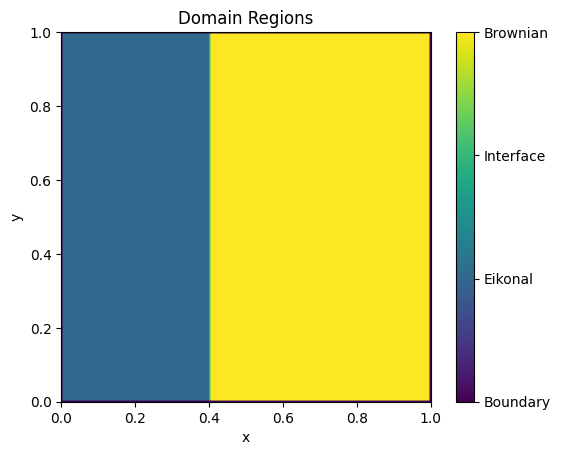

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
N = 250
om = np.zeros((N,N))

#Construction of Interface
CreateInterfase(om, 2, N, I_3)

#Construction of Domain
Build_Eik_Brown(om, N)

#Save domain
plot_om_and_download(om, "T1_domain.png")

#Create A and Brownin hash tables
C_to_P, P_to_C, dim = HashTablesBrownian(om, N)
A = CreateMatrixBrownian(C_to_P, P_to_C, dim, om)

#Solve
vv = Solve_One_Player(om, 1000, dim, N, A, C_to_P, P_to_C, I_3, H, G)

#Plot and Save
plot_solution(vv/N, I_3, "T1_sol_level.png")

# Run a loop for different azimuth angles
for i, azimuth_angle in enumerate(np.linspace(0, 360, 15)):
    filename = f"T1_3d_azimuth_{int(azimuth_angle)}.png"
    plot_and_download_3d(vv, N, azimuth_angle, filename)

#Plot interface
plot_interface_and_download(I_3, N, vv, "T1_interface.png")

#H, G, I_1

In [ ]:
N = 250
om = np.zeros((N,N))

#Construction of Interface
CreateInterfase(om, 2, N, I_1)

#Construction of Domain
Build_Eik_Brown(om, N)

#Save domain
plot_om_and_download(om, "T2_domain.png")

#Create A and Brownin hash tables
C_to_P, P_to_C, dim = HashTablesBrownian(om, N)
A = CreateMatrixBrownian(C_to_P, P_to_C, dim, om)

#Solve
vv = Solve_One_Player(om, 1000, dim, N, A, C_to_P, P_to_C, I_1, H, G)

#Plot and Save
plot_solution(vv/N, I_1, "T2_sol_level.png")

# Run a loop for different azimuth angles
for i, azimuth_angle in enumerate(np.linspace(0, 360, 15)):
    filename = f"T2_3d_azimuth_{int(azimuth_angle)}.png"
    plot_and_download_3d(vv, N, azimuth_angle, filename)

#Plot interface
plot_interface_and_download(I_1, N, vv, "T2_interface.png")

In [ ]:
N = 250
om = np.zeros((N,N))

#Construction of Interface
CreateInterfase(om, 2, N, I_1)

#Construction of Domain
Build_Eik_Brown(om, N)

#Save domain
plot_om_and_download(om, "T3_domain.png")

#Create A and Brownin hash tables
C_to_P, P_to_C, dim = HashTablesBrownian(om, N)
A = CreateMatrixBrownian(C_to_P, P_to_C, dim, om)

#Solve
vv = Solve_One_Player(om, 1000, dim, N, A, C_to_P, P_to_C, I_1, H2, G2)

#Plot and Save
plot_solution(vv/N, I_1, "T3_sol_level.png")

# Run a loop for different azimuth angles
for i, azimuth_angle in enumerate(np.linspace(0, 360, 15)):
    filename = f"T3_3d_azimuth_{int(azimuth_angle)}.png"
    plot_and_download_3d(vv, N, azimuth_angle, filename)

#Plot interface
plot_interface_and_download(I_1, N, vv, "T3_interface.png")

In [ ]:
N = 250
om = np.zeros((N,N))

#Construction of Interface
CreateInterfase(om, 2, N, I_3)

#Construction of Domain
Build_Eik_Brown(om, N)

#Save domain
plot_om_and_download(om, "T4_domain.png")

#Create A and Brownin hash tables
C_to_P, P_to_C, dim = HashTablesBrownian(om, N)
A = CreateMatrixBrownian(C_to_P, P_to_C, dim, om)

#Solve
vv = Solve_One_Player(om, 1000, dim, N, A, C_to_P, P_to_C, I_3, H2, G2)

#Plot and Save
plot_solution(vv/N, I_3, "T4_sol_level.png")

# Run a loop for different azimuth angles
for i, azimuth_angle in enumerate(np.linspace(0, 360, 15)):
    filename = f"T4_3d_azimuth_{int(azimuth_angle)}.png"
    plot_and_download_3d(vv, N, azimuth_angle, filename)

#Plot interface
plot_interface_and_download(I_3, N, vv, "T4_interface.png")